In [1]:
# Resources:
# https://www.linkedin.com/pulse/data-analytics-understanding-resale-prices-hdb-houses-bannister?trk=read_related_article-card_title
# https://towardsdatascience.com/data-driven-approach-to-understanding-hdb-resale-prices-in-singapore-31c3beecfd97
# https://medium.com/analytics-vidhya/singapores-kiasu-parents-understanding-hdb-resale-prices-through-data-analysis-85b4edead6e2

# Predicting resale prices:
# flat size, distance from central, distance from MRT, distance from good school, remaining lease

# latitude/longitude information: onemap.sg

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from dateutil.relativedelta import relativedelta
from sklearn import compose
from sklearn import pipeline
from sklearn import preprocessing, ensemble
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

rng = 42

In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# system path
import sys
sys.path.insert(0,'/content/drive/My Drive/IT5006 Project')

In [6]:
#path to working folder: not required in Kaggle submission
mypath = '/content/drive/MyDrive/python/IT5006 Project 1/'
#mypath = '/content/drive/My Drive/IT5006 Project/' #Dennis' directory

## **Analysing the dataset**

In [7]:
data = pd.read_csv(mypath+"train.csv") #Joshua's directory
#data = pd.read_csv("/content/drive/My Drive/IT5006 Project/train.csv") #Dennis' directory
#data = pd.read_csv("/kaggle/input/hdbresale/train.csv")
data.head()

,town,lat,lng,month,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,GEYLANG,NaN,NaN,2006-01-01,4 ROOM,328,UBI AVE 1,04 TO 06,84.0,Simplified,1985.0,175000.0,NaN
1,JURONG EAST,NaN,NaN,2003-02-01,5 ROOM,271,TOH GUAN RD,10 TO 12,120.0,Improved,1999.0,353000.0,NaN
2,TOA PAYOH,NaN,NaN,2005-09-01,3 ROOM,205,TOA PAYOH NTH,10 TO 12,65.0,Improved,1973.0,215000.0,NaN
3,PASIR RIS,NaN,NaN,2001-03-01,EXECUTIVE,508,PASIR RIS ST 52,04 TO 06,146.0,Apartment,1993.0,482000.0,NaN
4,JURONG WEST,NaN,NaN,2014-07-01,EXECUTIVE,656B,JURONG WEST ST 61,10 TO 12,133.0,Apartment,2001.0,613000.0,NaN


In [8]:
data.isna().sum() #no. of missing data in each column

town                        0
lat                    462515
lng                    462515
month                       0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        337543
dtype: int64

In [9]:
data[data['remaining_lease'].notnull()] #checking format of filled cells

,town,lat,lng,month,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
5,BEDOK,NaN,NaN,2019-05-01,5 ROOM,102,LENGKONG TIGA,10 TO 12,130.0,Improved,1989.0,865000.0,69 years 02 months
16,BUKIT BATOK,NaN,NaN,2015-08-01,4 ROOM,350,BT BATOK ST 34,04 TO 06,104.0,Model A,1987.0,420000.0,70
17,JURONG WEST,NaN,NaN,2020-07-01,5 ROOM,138D,YUAN CHING RD,13 TO 15,108.0,DBSS,2014.0,710000.0,93 years 02 months
22,BUKIT PANJANG,NaN,NaN,2020-07-01,4 ROOM,204,PETIR RD,04 TO 06,106.0,Model A,1988.0,325000.0,67 years 03 months
25,BUKIT MERAH,NaN,NaN,2018-03-01,4 ROOM,38,JLN RUMAH TINGGI,19 TO 21,99.0,Model A,1997.0,618000.0,78 years 04 months
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462486,BEDOK,NaN,NaN,2015-11-01,4 ROOM,110,BEDOK NTH RD,04 TO 06,91.0,New Generation,1977.0,418000.0,60
462488,KALLANG/WHAMPOA,NaN,NaN,2021-03-01,4 ROOM,15,BEACH RD,13 TO 15,77.0,Improved,1975.0,480000.0,52 years 11 months
462489,QUEENSTOWN,NaN,NaN,2020-09-01,4 ROOM,91,DAWSON RD,28 TO 30,83.0,Premium Apartment,2016.0,825000.0,94 years 07 months
462491,YISHUN,NaN,NaN,2017-09-01,4 ROOM,635,YISHUN ST 61,01 TO 03,104.0,Model A,1987.0,340000.0,68 years 11 months


## **Pre-processing**

In [10]:
X = data[['town','lat','lng','month','flat_type','block','street_name','storey_range','floor_area_sqm','flat_model','lease_commence_date','remaining_lease']]
y = data[['resale_price']]

In [11]:
class CustomTransformer( BaseEstimator, TransformerMixin ):    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X['month'] = pd.to_datetime(X['month'])
        X['lease_commence_date'] = pd.to_datetime(X['lease_commence_date'], format = '%Y')
        X['remaining_lease'] = (X['lease_commence_date']-X['month'])/np.timedelta64(1,"Y")+99
        def average_storey(x):
            return (int(x.split(' TO ')[0]) + int(x.split(' TO ')[-1]))/2
        X["storey"] = X["storey_range"].apply(lambda x: average_storey(x))
        return X

In [12]:
# change datetime format
X = CustomTransformer().fit_transform(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [13]:
# normalize lease commence date
mms = MinMaxScaler()
X[['n_lease_commence_date']] = mms.fit_transform(X[['lease_commence_date']])


In [14]:
X = X[["town", "flat_type", "storey", "floor_area_sqm", "flat_model", "remaining_lease", "n_lease_commence_date", "block", "street_name", "lat", "lng"]]

In [15]:
class OHE_with_names(BaseEstimator,TransformerMixin):
    def fit(self, X, column, y=None):
        self.column = column
        self.column_names_ = []

        ohe = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.ohe = ohe.fit(X[[self.column]])

        feature_names = ohe.get_feature_names()
        feature_names = [x.replace("x0_", "") for x in feature_names]
        feature_names = [f"{self.column}[{x}]" for x in feature_names]

        self.column_names_.append(feature_names)

        return self

    def transform(self, X):
        transformed_col = self.ohe.transform(X[[self.column]])

        df_col = pd.DataFrame(transformed_col, columns=self.column_names_[0])

        return pd.concat([X,df_col],axis=1).drop(columns=self.column)

In [16]:
#OneHotEncoding
X = OHE_with_names().fit_transform(X,column='flat_type')
X = OHE_with_names().fit_transform(X,column='town')
X = OHE_with_names().fit_transform(X,column='flat_model')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## **Imputing new features - Geographical coordinates and distance from important locations**

In [17]:
#preparing zipcode file, making second 'postal' column the main column and removing duplicated rows
zip_code = pd.read_csv(mypath+'sg_zipcode_mapper.csv', encoding='latin-1')
zip_code = zip_code.rename({"road_name":"street_name","latitude":"lat","longtitude":"lng"}, axis=1)
zip_code['full_street_name'] = zip_code['blk_no']+' '+zip_code['street_name']
zip_code.drop(['postal'], axis=1, inplace=True)
zip_code.rename(columns = {'postal.1':'postal'}, inplace=True)
zip_code.drop_duplicates(subset=['postal'],inplace=True)
zip_code.drop_duplicates(subset=['full_street_name'],inplace=True)
zip_code

,lat,lng,searchval,blk_no,street_name,building,address,postal,full_street_name
0,1.312763,103.883519,# 1 LOFT,1,LORONG 24 GEYLANG,# 1 LOFT,1 LORONG 24 GEYLANG # 1 LOFT SINGAPORE 398614,398614,1 LORONG 24 GEYLANG
1,1.312390,103.881504,# 1 SUITES,1,LORONG 20 GEYLANG,# 1 SUITES,1 LORONG 20 GEYLANG # 1 SUITES SINGAPORE 398721,398721,1 LORONG 20 GEYLANG
2,1.309135,103.679463,1 BENOI ROAD SINGAPORE 629875,1,BENOI ROAD,NIL,1 BENOI ROAD SINGAPORE 629875,629875,1 BENOI ROAD
3,1.305466,103.895674,1 BOSCOMBE ROAD SINGAPORE 439731,1,BOSCOMBE ROAD,NIL,1 BOSCOMBE ROAD SINGAPORE 439731,439731,1 BOSCOMBE ROAD
4,1.344619,103.749789,1 BUKIT BATOK STREET 22 SINGAPORE 659592,1,BUKIT BATOK STREET 22,NIL,1 BUKIT BATOK STREET 22 SINGAPORE 659592,659592,1 BUKIT BATOK STREET 22
...,...,...,...,...,...,...,...,...,...
25288,1.306246,103.849956,ZHUJIAO CENTRE (TEKKA MARKET),662,BUFFALO ROAD,ZHUJIAO CENTRE (TEKKA MARKET),662 BUFFALO ROAD ZHUJIAO CENTRE (TEKKA MARKET)...,210662,662 BUFFALO ROAD
25289,1.305681,103.850858,ZHUJIAO CENTRE (TEKKA MARKET),663,BUFFALO ROAD,ZHUJIAO CENTRE (TEKKA MARKET),663 BUFFALO ROAD ZHUJIAO CENTRE (TEKKA MARKET)...,210663,663 BUFFALO ROAD
25290,1.306133,103.851113,ZHUJIAO CENTRE (TEKKA MARKET),664,BUFFALO ROAD,ZHUJIAO CENTRE (TEKKA MARKET),664 BUFFALO ROAD ZHUJIAO CENTRE (TEKKA MARKET)...,210664,664 BUFFALO ROAD
25291,1.347091,103.854878,ZION BISHAN BIBLE PRESBYTERIAN CHURCH,4,BISHAN STREET 13,ZION BISHAN BIBLE PRESBYTERIAN CHURCH,4 BISHAN STREET 13 ZION BISHAN BIBLE PRESBYTER...,579792,4 BISHAN STREET 13


In [18]:
#replace short forms in original dataframe
replacers= {
    'AVE':'AVENUE',
    'RD' : 'ROAD',
    'NTH' : 'NORTH',
    'ST' : 'STREET',
    'LOR' : 'LORONG',
    'DR' : 'DRIVE',
    'HTS' : 'HEIGHTS',
    'JLN' : 'JALAN',
    'TER' : 'TERRACE',
    'BT' : 'BUKIT',
    'PK' : 'PARK',
    'CRES' : 'CRESCENT',
    'GDNS' : 'GARDENS',
    'CTRL' : 'CENTRAL',
    'C\'WEALTH' : 'COMMONWEALTH',
    'CL' : 'CLOSE',
    'UPP' : 'UPPER',
    'PL' : 'PLACE',
    'STH' : 'SOUTH',
    'ST.' : 'SAINT',
    'TG' : 'TANJONG',
    'KG' : 'KAMPONG',
    'MKT' : 'MARKET'
}
X['street_name'] = X['street_name'].apply(lambda x: ' '.join([replacers[word] if word in replacers else word for word in x.split()]))
X['full_street_name'] = X['block']+' '+X['street_name']
X = X.merge(zip_code[['full_street_name','postal']],on='full_street_name',how='left')

In [19]:
#further imputing missing data by using similar filled data
X[['postal']] = X[['postal']].fillna(
    X.groupby('street_name').ffill()
)

In [20]:
#drop the rest of the na data
X.dropna(subset=['postal'],inplace=True)

In [21]:
#match lat and lng to postal code
for col in ['lat','lng']:
  X[col] = X[col].fillna(X['postal'].map(zip_code.set_index('postal')[col]))

In [22]:
#find nearest mrt station
import geopy.distance

mrt_df = pd.read_csv(mypath+'mrt_lrt_data.csv')

def nearest_mrt(n):
  curr_dis = 999999
  ind = None
  coords_1 = (n['lat'],n['lng'])
  for i in mrt_df.index: 
    coords_2 = (mrt_df['lat'][i],mrt_df['lng'][i])
    try:
      dis = geopy.distance.vincenty(coords_1,coords_2).km
    except:
      return None
    if dis < curr_dis:
      curr_dis = dis
      ind = i
  return mrt_df['station_name'][ind], curr_dis

X['mrt_distance'] = X.apply(nearest_mrt,axis=1)
X[['nearest_mrt','mrt_distance']] = pd.DataFrame([*X['mrt_distance']], X.index)

In [23]:
school_df = pd.read_csv(mypath+'primary_school_data.csv')
school_df

,school_name,lat,lng
0,Rosyth School,1.37319,103.87468
1,Nanyang Primary School,1.32126,103.80767
2,Catholic High School (Primary Section),1.35487,103.84516
3,Nan Hua Primary School,1.32005,103.76192
4,Tao Nan School,1.30508,103.91149
5,Henry Park Primary School,1.31704,103.78405
6,Anglo-Chinese School (Primary),1.31898,103.83585
7,St. Hilda's Primary School,1.34993,103.93606
8,Raffles Girls' Primary School,1.33017,103.80626
9,CHIJ St. Nicholas Girls' School (Primary Section),1.37424,103.83418


In [24]:
#find nearest number of primary schools

def number_of_good_schools_nearby(n):
  num = 0 # initialize
  schools = [] # initialize
  coords_1 = (n['lat'],n['lng'])
  for i in school_df.index: 
    coords_2 = (school_df['lat'][i],school_df['lng'][i])
    try:
      dist = geopy.distance.vincenty(coords_1,coords_2).km
    except:
      return None
    if dist <= 1:
      num += 1
      schools.append(school_df['school_name'][i])
  return num, schools
  
X['num_of_prestigious_sch_nearby'] = X.apply(number_of_good_schools_nearby,axis=1)
X[['num_of_prestigious_sch_nearby','prestigious_schools']] = pd.DataFrame([*X['num_of_prestigious_sch_nearby']], X.index)

In [25]:
y = y.join(X)
y.dropna(inplace=True)
y = y[['resale_price']]

In [26]:
X

,storey,floor_area_sqm,remaining_lease,n_lease_commence_date,block,street_name,lat,lng,flat_type[1 ROOM],flat_type[2 ROOM],...,flat_model[Standard],flat_model[Terrace],flat_model[Type S1],flat_model[Type S2],full_street_name,postal,mrt_distance,nearest_mrt,num_of_prestigious_sch_nearby,prestigious_schools
0,5.0,84.0,78.000253,0.358508,328,UBI AVENUE 1,1.327564,103.904805,0.0,0.0,...,0.0,0.0,0.0,0.0,328 UBI AVENUE 1,400328.0,0.709416,Ubi,0,[]
1,11.0,120.0,94.915043,0.622637,271,TOH GUAN ROAD,1.341682,103.746246,0.0,0.0,...,0.0,0.0,0.0,0.0,271 TOH GUAN ROAD,600271.0,0.897899,Bukit Batok,0,[]
2,11.0,65.0,66.334031,0.132090,205,TOA PAYOH NORTH,1.342275,103.848050,0.0,0.0,...,0.0,0.0,0.0,0.0,205 TOA PAYOH NORTH,310205.0,0.218192,Braddell,0,[]
3,5.0,146.0,90.838299,0.509453,508,PASIR RIS STREET 52,1.376150,103.944239,0.0,0.0,...,0.0,0.0,0.0,0.0,508 PASIR RIS STREET 52,510508.0,0.653124,Pasir Ris,0,[]
4,11.0,133.0,85.504856,0.660399,656B,JURONG WEST STREET 61,1.335913,103.699426,0.0,0.0,...,0.0,0.0,0.0,0.0,656B JURONG WEST STREET 61,642656.0,0.294109,Pioneer,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462510,23.0,121.0,94.000582,0.603781,267,TOH GUAN ROAD,1.341117,103.744795,0.0,0.0,...,0.0,0.0,0.0,0.0,267 TOH GUAN ROAD,600267.0,0.917422,Jurong East,0,[]
462511,11.0,111.0,81.751186,0.471691,716,JURONG WEST STREET 71,1.344052,103.696710,0.0,0.0,...,0.0,0.0,0.0,0.0,716 JURONG WEST STREET 71,640716.0,0.712890,Pioneer,0,[]
462512,8.0,110.0,90.085375,0.698109,294,PUNGGOL CENTRAL,1.402572,103.904635,0.0,0.0,...,0.0,0.0,0.0,0.0,294 PUNGGOL CENTRAL,820294.0,0.359720,Cove,0,[]
462513,8.0,127.0,91.251723,0.566019,862,WOODLANDS STREET 83,1.439955,103.795049,0.0,0.0,...,0.0,0.0,0.0,0.0,862 WOODLANDS STREET 83,730862.0,1.016383,Woodlands,0,[]


In [27]:
y

,resale_price
0,175000.0
1,353000.0
2,215000.0
3,482000.0
4,613000.0
...,...
462510,368500.0
462511,262000.0
462512,560000.0
462513,280000.0


## **Modeling the prediction tool and analysing results**

**1. Linear regression model**

In [28]:
trial_X = X.copy()
trial_y = y.copy()

In [29]:
trial_X = trial_X.drop(X.columns[[4,5,6,7,61,62,64,66]], axis=1)

In [30]:
trial_y['resale_price'] = trial_y['resale_price']/10000

In [31]:
trial_X = trial_X.iloc[:,[0,1,2,3,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58]].copy()

#flat_type: 4-10 [4,5,6,7,8,9,10]
#town: 11-36 [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
#flat_model: 37-56 [37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56]

In [32]:
#X = X.drop(X.columns[[4,5,6,7,61,62,64,66]], axis=1)

In [33]:
trial_X.describe()

,storey,floor_area_sqm,remaining_lease,n_lease_commence_date,flat_type[2 ROOM],flat_type[3 ROOM],flat_type[4 ROOM],flat_type[5 ROOM],flat_type[EXECUTIVE],flat_type[MULTI-GENERATION],...,flat_model[Premium Apartment],flat_model[Premium Apartment Loft],flat_model[Premium Maisonette],flat_model[Simplified],flat_model[Standard],flat_model[Terrace],flat_model[Type S1],flat_model[Type S2],mrt_distance,num_of_prestigious_sch_nearby
count,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,...,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000,462083.000000
mean,7.807762,96.855776,78.840613,0.448889,0.010619,0.290201,0.393072,0.229316,0.075551,0.000437,...,0.069258,0.000143,0.000156,0.055111,0.040454,0.000753,0.000623,0.000314,0.690978,0.099318
std,4.945672,25.152098,10.966448,0.202705,0.102501,0.453856,0.488433,0.420393,0.264279,0.020904,...,0.253893,0.011950,0.012482,0.228198,0.197021,0.027433,0.024958,0.017712,0.420443,0.304566
min,2.000000,28.000000,43.250738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002224,0.000000
25%,5.000000,74.000000,70.837889,0.320746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.370926,0.000000
50%,8.000000,98.000000,79.418489,0.415074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.608912,0.000000
75%,11.000000,113.000000,88.166102,0.603781,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.917742,0.000000
max,50.000000,297.000000,100.333361,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.420324,2.000000


In [34]:
from sklearn.preprocessing import StandardScaler
mms = MinMaxScaler()
scaler = StandardScaler()
sscaler = compose.ColumnTransformer(transformers = [('scaler',StandardScaler(),[
                                                                                'storey',
                                                                                'floor_area_sqm',
                                                                                'remaining_lease',
                                                                                #'mrt_distance'
                                                                                ])], remainder='passthrough')
mmscaler = compose.ColumnTransformer(transformers = [('scaler',mms,[
                                                                    'storey',
                                                                    'floor_area_sqm',
                                                                    'remaining_lease',
                                                                    #'mrt_distance'
                                                                    ])], remainder='passthrough')
column_names = list(trial_X.columns.values)
preprocd_data = sscaler.fit_transform(trial_X)
trial_X = pd.DataFrame(preprocd_data)
trial_X.columns=column_names

In [35]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
model = linreg.fit(trial_X,trial_y)
r_sq = model.score(trial_X,trial_y)
print(r_sq)

0.8328787058588719


In [36]:
s1 = pd.Series(trial_X.columns)
s2 = pd.Series(model.coef_[0])
df = pd.concat([s1,s2], axis=1)

df

,0,1
0,storey,1.692913
1,floor_area_sqm,4.801455
2,remaining_lease,-13.213291
3,n_lease_commence_date,80.864018
4,flat_type[2 ROOM],1.024486
5,flat_type[3 ROOM],6.731874
6,flat_type[4 ROOM],10.264703
7,flat_type[5 ROOM],14.948116
8,flat_type[EXECUTIVE],18.104467
9,flat_type[MULTI-GENERATION],10.533850


In [37]:
df.reindex(df[1].abs().sort_values(ascending=False).index).reset_index()

,index,0,1
0,3,n_lease_commence_date,80.864018
1,53,flat_model[Type S2],28.214083
2,51,flat_model[Terrace],25.684642
3,52,flat_model[Type S1],23.108794
4,8,flat_type[EXECUTIVE],18.104467
5,47,flat_model[Premium Apartment Loft],17.446232
6,7,flat_type[5 ROOM],14.948116
7,24,town[MARINE PARADE],14.875345
8,28,town[SEMBAWANG],-14.374789
9,2,remaining_lease,-13.213291


**Results of Linear Regression**

Distance of the nearest MRT station is inversely related to the resale price, as expected since larger distance would indicate less transportation convenience and hence lower resale price. From the magnitude of the co-efficients, MRT distance has low significance on the overall resale price with a ranking of 34 when ranked by absolute co-efficient value.

No. of prestigious primary schools nearby fares even more poorly, ranking 54 out of 56 features, indicating almost no impact on the overall price. 

**2. OLS analysis**

In [38]:
import statsmodels.api as sm

est = sm.OLS(trial_y.reset_index(drop = True), trial_X.reset_index(drop = True)).fit() 
est.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           resale_price   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          3.020e+05
Date:                Tue, 19 Apr 2022   Prob (F-statistic):                        0.00
Time:                        11:03:53   Log-Likelihood:                     -1.4982e+06
No. Observations:              462083   AIC:                                  2.997e+06
Df Residuals:                  462028   BIC:                                  2.997e+06
Df Model:                          55                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
storey                                 1.6931      0.010    172.960      0.000       1.674       1.712
floor_area_sqm                         4.8062      0.042    113.358      0.000       4.723       4.889
remaining_lease                      -13.2129      0.016   -813.148      0.000     -13.245     -13.181
n_lease_commence_date                 80.8623      0.104    780.520      0.000      80.659      81.065
flat_type[2 ROOM]                      0.8823      0.329      2.686      0.007       0.238       1.526
flat_type[3 ROOM]                      6.5963      0.321     20.530      0.000       5.967       7.226
flat_type[4 ROOM]                     10.1244      0.332     30.457      0.000       9.473      10.776
flat_type[5 ROOM]                     14.8027      0.351     42.193      0.000      14.115      15.490
flat_type[EXECUTIVE]                  17.9560      0.379     47.420      0.000      17.214      18.698
flat_type[MULTI-GENERATION]            9.4373      0.228     41.335      0.000       8.990       9.885
town[BEDOK]                           -2.3153      0.057    -40.864      0.000      -2.426      -2.204
town[BISHAN]                           4.4911      0.081     55.622      0.000       4.333       4.649
town[BUKIT BATOK]                     -5.9980      0.063    -95.122      0.000      -6.122      -5.874
town[BUKIT MERAH]                      6.2190      0.068     91.599      0.000       6.086       6.352
town[BUKIT PANJANG]                  -12.8376      0.072   -179.023      0.000     -12.978     -12.697
town[BUKIT TIMAH]                      7.9456      0.190     41.866      0.000       7.574       8.318
town[CENTRAL AREA]                     3.7441      0.131     28.569      0.000       3.487       4.001
town[CHOA CHU KANG]                  -12.2591      0.066   -185.704      0.000     -12.389     -12.130
town[CLEMENTI]                         1.5966      0.069     23.012      0.000       1.461       1.733
town[GEYLANG]                         -0.1455      0.074     -1.964      0.049      -0.291      -0.000
town[HOUGANG]                         -5.5009      0.060    -91.965      0.000      -5.618      -5.384
town[JURONG EAST]                     -4.9205      0.072    -68.023      0.000      -5.062      -4.779
town[JURONG WEST]                     -9.0403      0.059   -154.254      0.000      -9.155      -8.925
town[KALLANG/WHAMPOA]                  1.3129      0.073     17.969      0.000       1.170       1.456
town[MARINE PARADE]                   14.8735      0.122    121.675      0.000      14.634      15.113
town[PASIR RIS]                       -5.1350      0.071    -72.806      0.000      -5.273      -4.9

In [39]:
# Define function to output plot of the model coefficients
# credits from https://medium.com/analytics-vidhya/create-your-own-coefficient-plot-function-in-python-aadb9fe27a77
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=13, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=5, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


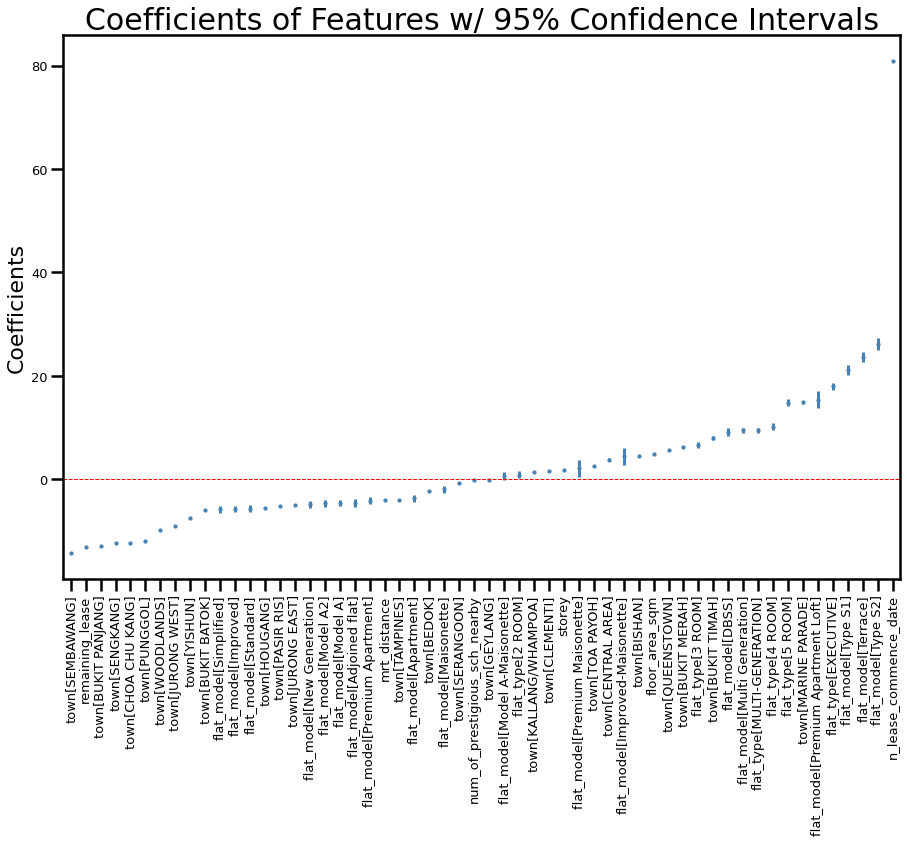

In [40]:
# Plot coefficients w/95% confidence intervals for Model

coefplot(est)

**3. Heatmap visualization**

In [41]:
df = X.copy()
df['resale_price'] = y.copy()

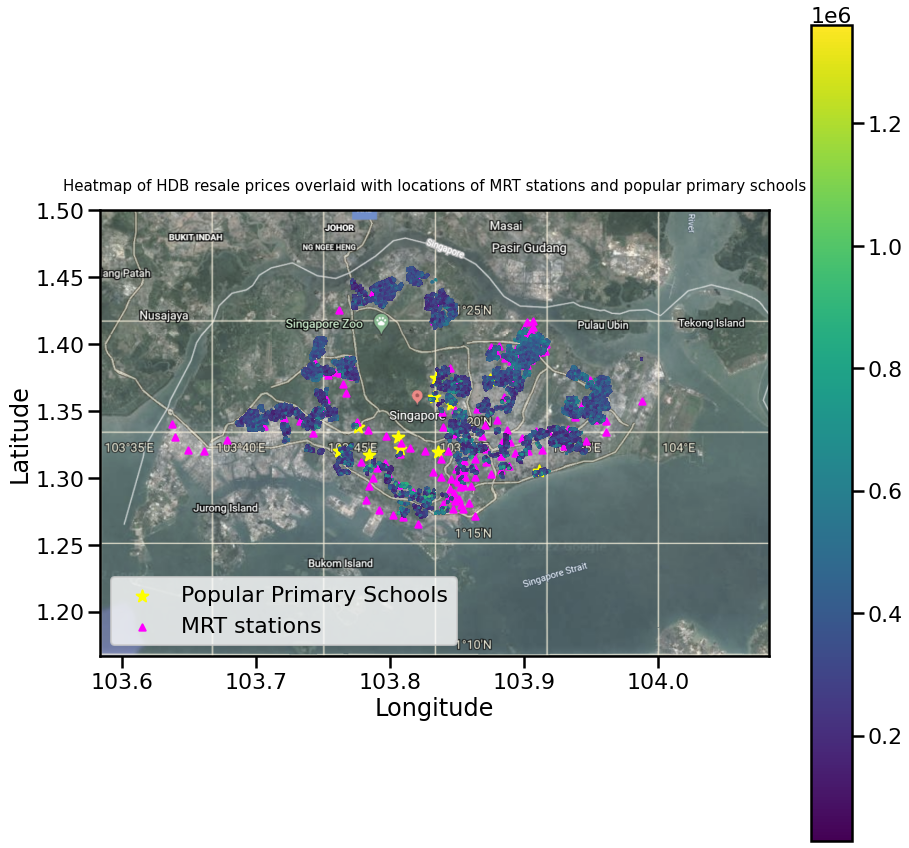

In [42]:
import matplotlib.pyplot as plt

# Image taken from Google Earth
sg_map = plt.imread(mypath+"Singapore_Map.png")

# Coordinates taken from Google Earth
BBox = [103.5833, 104.0833, 1.1667, 1.5] 

# Plot heatmap
fig, ax = plt.subplots(figsize = (15,15))
plt.imshow(sg_map, extent=BBox, aspect="equal")
plt.scatter(school_df.lng, school_df.lat, s = 150, marker = '*', c = 'yellow', label = 'Popular Primary Schools')
plt.scatter(mrt_df.lng, mrt_df.lat, s = 40, marker = '^', c = 'magenta', label = 'MRT stations')
plt.scatter(df.lng, df.lat, c = df.resale_price, s=0.5)

plt.colorbar()
plt.title("Heatmap of HDB resale prices overlaid with locations of MRT stations and popular primary schools", fontsize=15, pad =20) # set title for entire plot
plt.ylabel("Latitude")
plt.xlabel("Longitude")
ax.legend()

**4. Further analysis by narrowing down into larger flats**

In [43]:
trial_X = X.copy()
trial_y = y.copy()

trial_X = trial_X.drop(X.columns[[4,5,6,7,61,62,64,66]], axis=1)
trial_y['resale_price'] = trial_y['resale_price']/10000

In [44]:
trial_X = trial_X[(trial_X['flat_type[3 ROOM]'] == 1) | (trial_X['flat_type[4 ROOM]'] == 1) | (trial_X['flat_type[5 ROOM]'] == 1) | (trial_X['flat_type[EXECUTIVE]'] == 1) | (trial_X['flat_type[MULTI-GENERATION]'] == 1)]

In [45]:
trial_y = trial_y.join(trial_X)
trial_y.dropna(inplace=True)
trial_y = trial_y[['resale_price']]

In [46]:
trial_X = trial_X.iloc[:,[0,1,2,3,6,7,8,9,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58]].copy()

In [47]:
column_names = list(trial_X.columns.values)
preprocd_data = sscaler.fit_transform(trial_X)
trial_X = pd.DataFrame(preprocd_data)
trial_X.columns=column_names

In [48]:
trial_X = trial_X.loc[:, (trial_X != 0).any(axis=0)]

In [49]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
model = linreg.fit(trial_X,trial_y)
r_sq = model.score(trial_X,trial_y)
print(r_sq)

s1 = pd.Series(trial_X.columns)
s2 = pd.Series(model.coef_[0])
df = pd.concat([s1,s2], axis=1)

df

0.8315291439917241


,0,1
0,storey,1.705700e+00
1,floor_area_sqm,4.695408e+00
2,remaining_lease,-1.314402e+01
3,n_lease_commence_date,8.123299e+01
4,flat_type[3 ROOM],-1.552134e+12
5,flat_type[4 ROOM],-1.552134e+12
6,flat_type[5 ROOM],-1.552134e+12
7,flat_type[EXECUTIVE],-1.552134e+12
8,town[BEDOK],-2.268207e+00
9,town[BISHAN],4.575226e+00


**Results of further analysis**

Attempted to examine the impact that no. of prestigious primary schools nearby on the resale price of larger flats (3 rooms and above) by filtering the dataframe first. The co-efficient of the feature is still low compared to other features.

## **Extra code for plotting and checking data**

In [50]:
trial_X.astype(bool).sum(axis=0)

storey                                456805
floor_area_sqm                        456805
remaining_lease                       456805
n_lease_commence_date                 456784
flat_type[3 ROOM]                     134097
flat_type[4 ROOM]                     181632
flat_type[5 ROOM]                     105963
flat_type[EXECUTIVE]                   34911
town[BEDOK]                            28639
town[BISHAN]                            9587
town[BUKIT BATOK]                      20017
town[BUKIT MERAH]                      16052
town[BUKIT PANJANG]                    16034
town[BUKIT TIMAH]                       1180
town[CENTRAL AREA]                      2959
town[CHOA CHU KANG]                    21409
town[CLEMENTI]                         12239
town[GEYLANG]                          12259
town[HOUGANG]                          25172
town[JURONG EAST]                      11634
town[JURONG WEST]                      34746
town[KALLANG/WHAMPOA]                  12923
town[MARIN

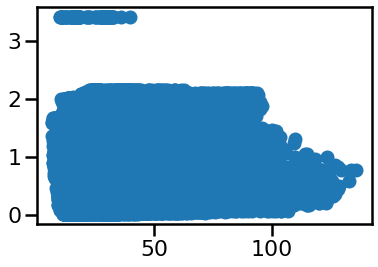

In [51]:
import matplotlib.pyplot as plt

plt.scatter(trial_y['resale_price'],trial_X['mrt_distance'])
#plt.scatter(X.index,X['num_of_prestigious_sch_nearby'])

plt.show()